# Static tuning

In [1]:
%cd ..

D:\Projects\Python\Euro-NeurIPS-2022


In [2]:
import glob
import itertools

import pandas as pd
from scipy import stats
import tomli

import tools

In [3]:
def res2data(where: str):
    with open(where, "r") as fh:
        data = fh.readlines()

    seed = int(where.split("-")[-1].removesuffix(".txt"))
    data = data[3:-5]  # remove headers and aggregate rows
    rows = [datum.strip().split() for datum in data]
    return [
        (inst, seed, int(cost), int(iters), tools.name2size(inst))
        for inst, feas, cost, iters, _ in rows
        if feas == "Y"
    ]

def size2group(size: int):
    if size < 300:
        return "small"
    elif 300 <= size <= 500:
        return "medium"
    else:
        return "large"

def read(group: str, exp: int):
    instances = glob.glob(f"data/tune/{group}/res-{exp}-*.txt")
    records = itertools.chain.from_iterable([res2data(inst) for inst in instances])

    df = pd.DataFrame(records, columns=["instance", "seed", "cost", "iters", "size"])
    df["size_group"] = df["size"].apply(size2group)
    df["exp"] = exp

    with open(f"data/tune/{group}/{exp}.toml", "rb") as fh:
        static_config = tomli.load(fh)

    for param, value in static_config["static"]["params"].items():
        df[param] = value
    
    return df

## Penalty parameters

In [4]:
dfs = [read("penalty", exp) for exp in range(1, 101)]
df = pd.concat(dfs)
df.head()

,instance,seed,cost,iters,size,size_group,exp,initialTimeWarpPenalty,nbPenaltyManagement,feasBooster,penaltyIncrease,penaltyDecrease,targetFeasible,repairProbability,repairBooster
0,ORTEC-VRPTW-ASYM-a9d4edc2-d1-n200-k15,1,146875,74832,200,small,1,1,100,2.0,1.2,0.85,0.4,50,10
1,ORTEC-VRPTW-ASYM-ef7dad5e-d1-n200-k12,1,123845,61663,200,small,1,1,100,2.0,1.2,0.85,0.4,50,10
2,ORTEC-VRPTW-ASYM-9016f313-d1-n200-k20,1,174610,75016,200,small,1,1,100,2.0,1.2,0.85,0.4,50,10
3,ORTEC-VRPTW-ASYM-fd32ebe8-d1-n201-k15,1,127563,45584,201,small,1,1,100,2.0,1.2,0.85,0.4,50,10
4,ORTEC-VRPTW-ASYM-8512fc31-d1-n201-k20,1,158456,64635,201,small,1,1,100,2.0,1.2,0.85,0.4,50,10


In [5]:
fields = [
    "initialTimeWarpPenalty",
    "nbPenaltyManagement",
    "feasBooster",
    "penaltyIncrease",
    "penaltyDecrease",
    "targetFeasible",
    "repairProbability",
    "repairBooster",    
]

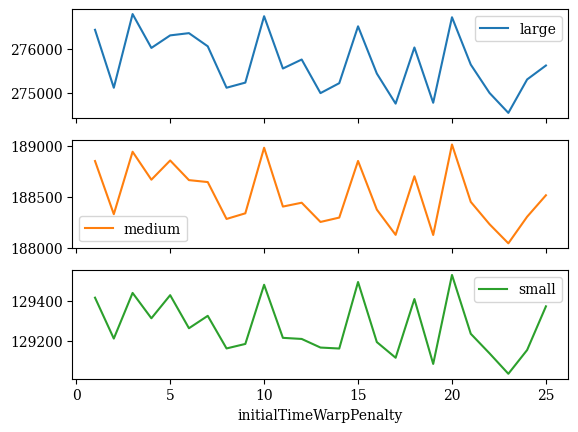

In [6]:
df.cost.groupby([df["initialTimeWarpPenalty"], df["size_group"]]).mean().unstack().plot(subplots=True);

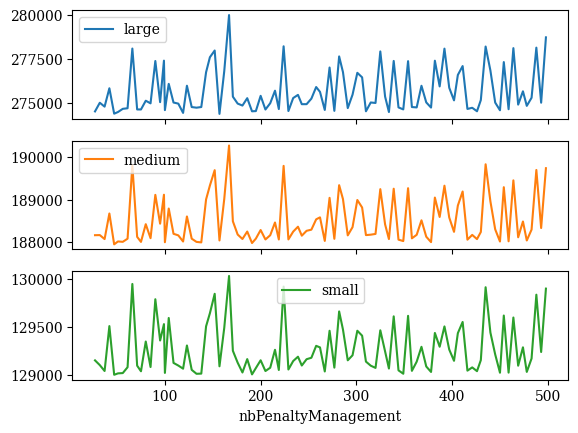

In [7]:
df.cost.groupby([df["nbPenaltyManagement"], df["size_group"]]).mean().unstack().plot(subplots=True);

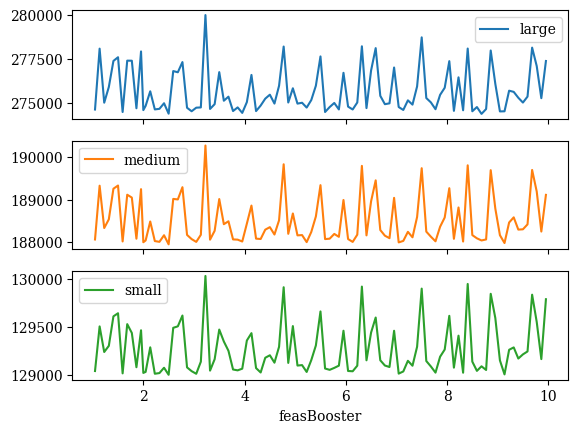

In [8]:
df.cost.groupby([df["feasBooster"], df["size_group"]]).mean().unstack().plot(subplots=True);

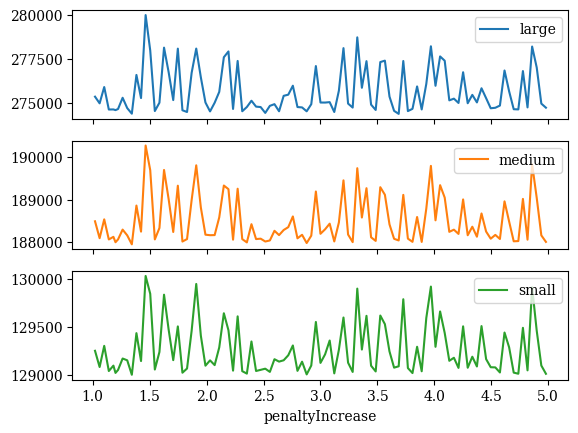

In [9]:
df.cost.groupby([df["penaltyIncrease"], df["size_group"]]).mean().unstack().plot(subplots=True);

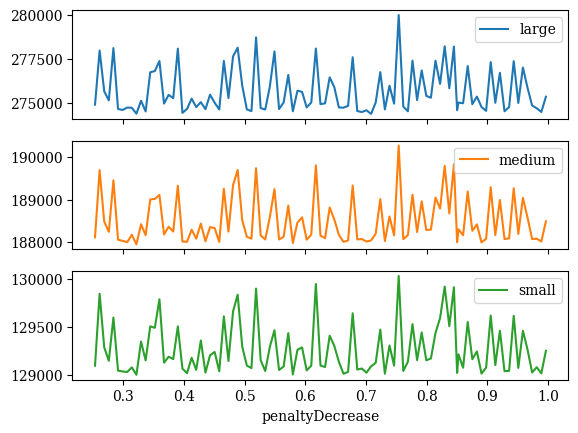

In [10]:
df.cost.groupby([df["penaltyDecrease"], df["size_group"]]).mean().unstack().plot(subplots=True);

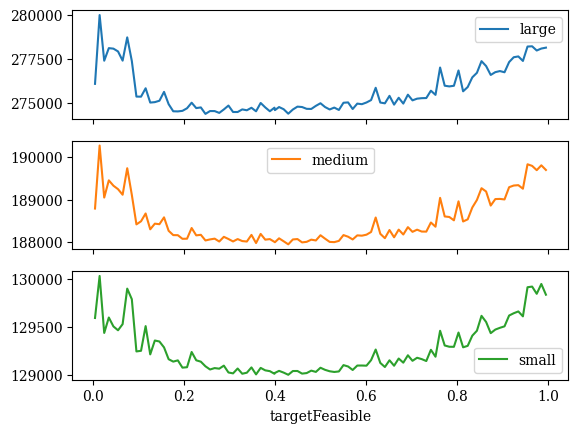

In [11]:
df.cost.groupby([df["targetFeasible"], df["size_group"]]).mean().unstack().plot(subplots=True);

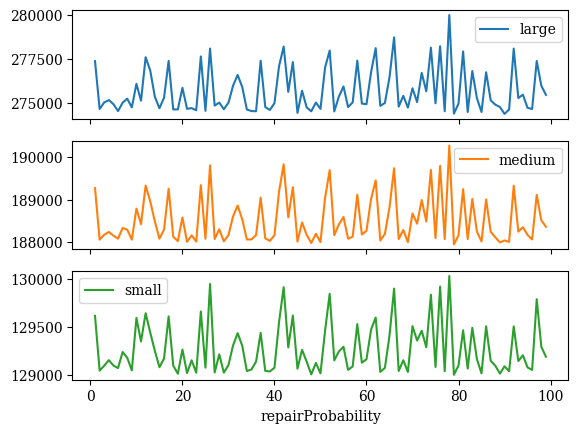

In [12]:
df.cost.groupby([df["repairProbability"], df["size_group"]]).mean().unstack().plot(subplots=True);

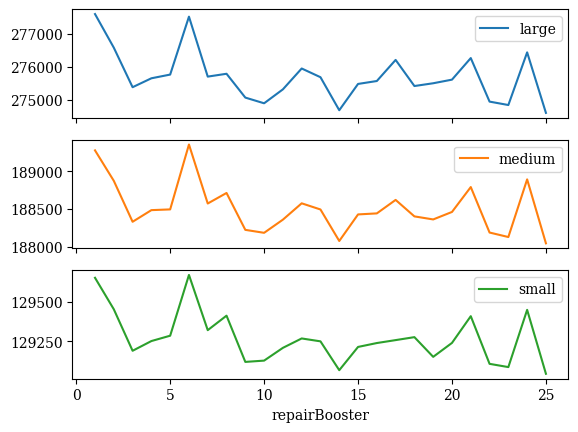

In [13]:
df.cost.groupby([df["repairBooster"], df["size_group"]]).mean().unstack().plot(subplots=True);

Is there any significant improvement?

In [14]:
mean_value = df[df.exp == 1].cost.mean()

for exp in range(1, 101):
    data = df[df.exp == exp]
    test = stats.ttest_1samp(data.cost, mean_value, alternative='less')
    mean = data.cost.mean()

    if mean <= mean_value:
        print(f"{exp:>3}  {test.pvalue:.2f}  {mean:.0f}")

  1  0.50  164331
 50  0.48  164288
 83  0.49  164311


So no: not really. Only two experiments are slightly better than the default on main, but the effect is nowhere near significant. 

Could we do better with separate configurations for each group size, rather than one size fits all?

In [15]:
best_per_group = []

for size in ["small", "medium", "large"]:
    grouped = df[df.size_group == size].groupby("exp").cost.mean()
    num_size = len(df[df.size_group == size]) / 1_000
    best_per_group.append((num_size, grouped.min()))

total = len(df) / 1_000
print(sum(num * val for num, val in best_per_group) / total)

164287.04979919677


No, not really. So the setting of scenario 50 seems best for all instances.

## Population parameters

In [16]:
dfs = [read("population", exp) for exp in range(1, 101)]
df = pd.concat(dfs)
df.head()

,instance,seed,cost,iters,size,size_group,exp,minPopSize,generationSize,nbElite,lbDiversity,ubDiversity,nbClose,nbIter
0,ORTEC-VRPTW-ASYM-a9d4edc2-d1-n200-k15,1,146875,58386,200,small,1,25,40,4,0.1,0.5,5,10000
1,ORTEC-VRPTW-ASYM-ef7dad5e-d1-n200-k12,1,123860,58440,200,small,1,25,40,4,0.1,0.5,5,10000
2,ORTEC-VRPTW-ASYM-9016f313-d1-n200-k20,1,174675,58478,200,small,1,25,40,4,0.1,0.5,5,10000
3,ORTEC-VRPTW-ASYM-fd32ebe8-d1-n201-k15,1,127563,42203,201,small,1,25,40,4,0.1,0.5,5,10000
4,ORTEC-VRPTW-ASYM-8512fc31-d1-n201-k20,1,158543,57583,201,small,1,25,40,4,0.1,0.5,5,10000


In [17]:
fields = [
    "minPopSize",
    "generationSize",
    "nbElite",
    "lbDiversity",
    "ubDiversity",
    "nbClose",
    "nbIter",
]

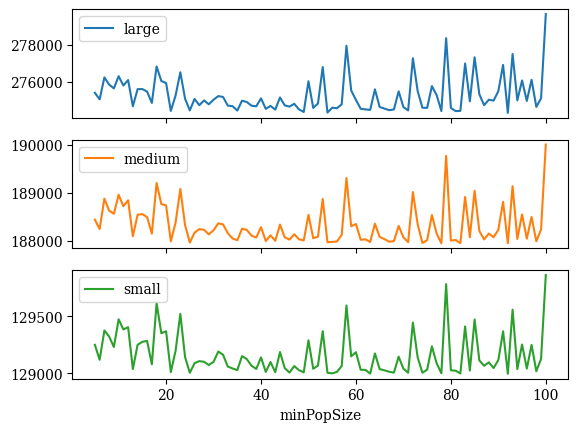

In [18]:
df.cost.groupby([df["minPopSize"], df["size_group"]]).mean().unstack().plot(subplots=True);

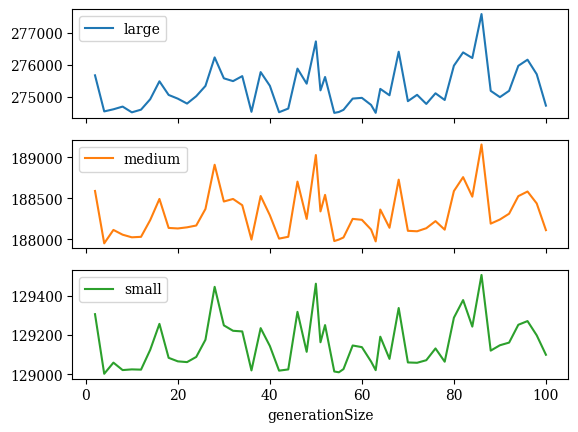

In [19]:
df.cost.groupby([df["generationSize"], df["size_group"]]).mean().unstack().plot(subplots=True);

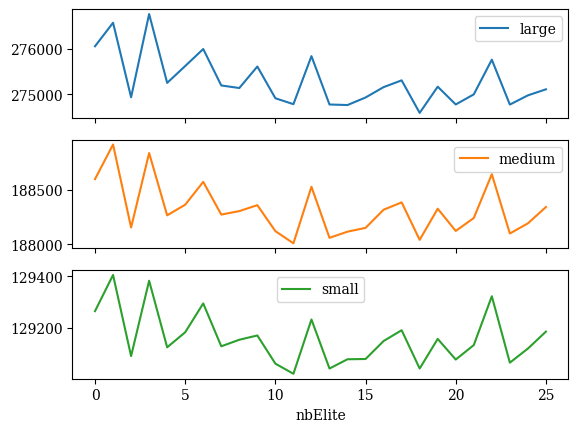

In [20]:
df.cost.groupby([df["nbElite"], df["size_group"]]).mean().unstack().plot(subplots=True);

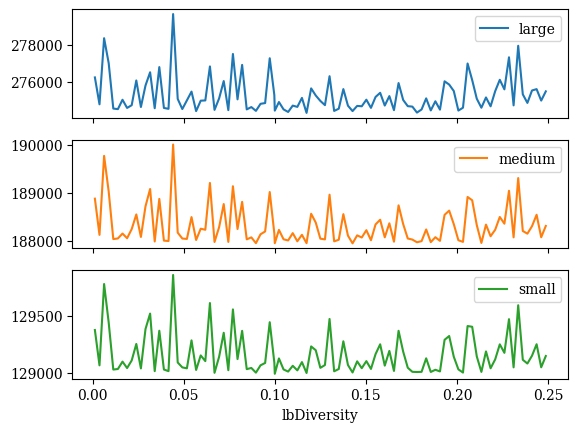

In [21]:
df.cost.groupby([df["lbDiversity"], df["size_group"]]).mean().unstack().plot(subplots=True);

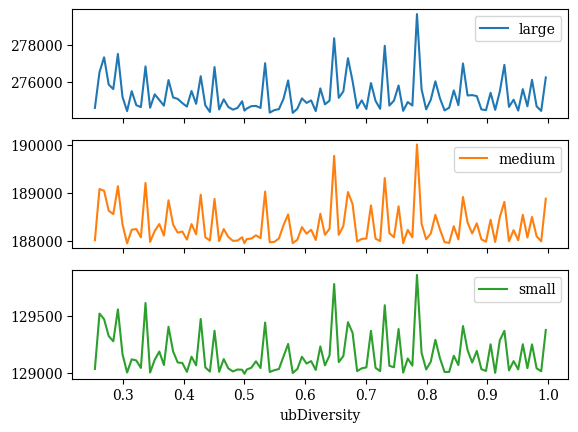

In [22]:
df.cost.groupby([df["ubDiversity"], df["size_group"]]).mean().unstack().plot(subplots=True);

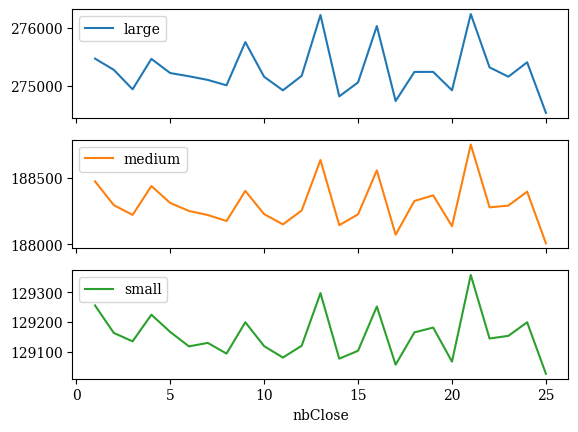

In [23]:
df.cost.groupby([df["nbClose"], df["size_group"]]).mean().unstack().plot(subplots=True);

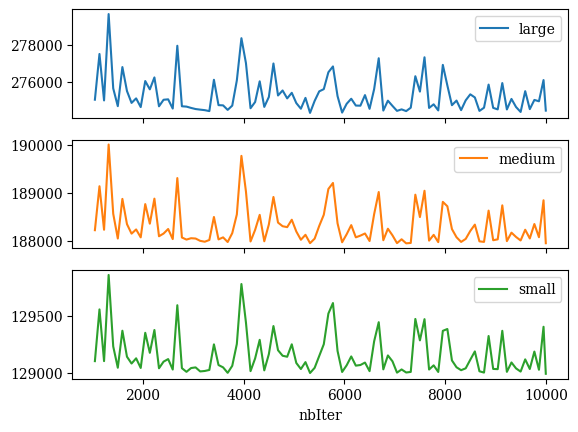

In [24]:
df.cost.groupby([df["nbIter"], df["size_group"]]).mean().unstack().plot(subplots=True);

In [25]:
mean_value = df[df.exp == 1].cost.mean()

for exp in range(1, 101):
    data = df[df.exp == exp]
    test = stats.ttest_1samp(data.cost, mean_value, alternative='less')
    mean = data.cost.mean()

    if mean <= mean_value:
        print(f"{exp:>3}  {test.pvalue:.2f}  {mean:.0f}")

  1  0.50  164287
 83  0.50  164284


In [26]:
best_per_group = []

for size in ["small", "medium", "large"]:
    grouped = df[df.size_group == size].groupby("exp").cost.mean()
    num_size = len(df[df.size_group == size]) / 1_000
    best_per_group.append((num_size, grouped.min()))

total = len(df) / 1_000
print(sum(num * val for num, val in best_per_group) / total)

164279.59759036146


## Granular neighbourhoods and intensification

In [27]:
dfs = [read("ls", exp) for exp in range(1, 101)]
df = pd.concat(dfs)
df.head()

,instance,seed,cost,iters,size,size_group,exp,nbGranular,weightWaitTime,weightTimeWarp,circleSectorOverlapToleranceDegrees,minCircleSectorSizeDegrees,postProcessPathLength
0,ORTEC-VRPTW-ASYM-a9d4edc2-d1-n200-k15,1,146875,59246,200,small,1,40,2,10,0,15,6
1,ORTEC-VRPTW-ASYM-ef7dad5e-d1-n200-k12,1,123860,57320,200,small,1,40,2,10,0,15,6
2,ORTEC-VRPTW-ASYM-9016f313-d1-n200-k20,1,174675,56576,200,small,1,40,2,10,0,15,6
3,ORTEC-VRPTW-ASYM-fd32ebe8-d1-n201-k15,1,127563,42279,201,small,1,40,2,10,0,15,6
4,ORTEC-VRPTW-ASYM-8512fc31-d1-n201-k20,1,158543,58125,201,small,1,40,2,10,0,15,6


In [28]:
fields = [
    "nbGranular",
    "weightWaitTime",
    "weightTimeWarp",
    "circleSectorOverlapToleranceDegrees",
    "minCircleSectorSizeDegrees",
    "postProcessPathLength",
]

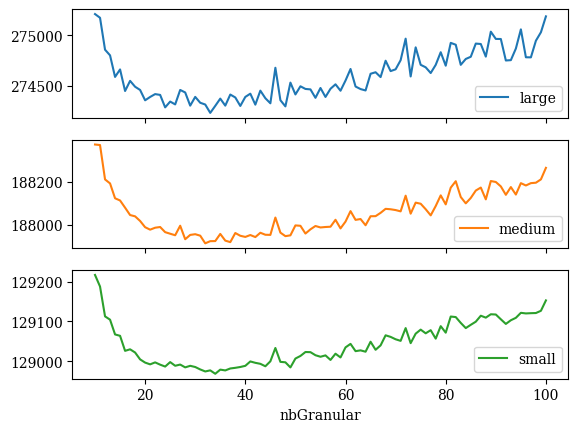

In [29]:
df.cost.groupby([df["nbGranular"], df["size_group"]]).mean().unstack().plot(subplots=True);

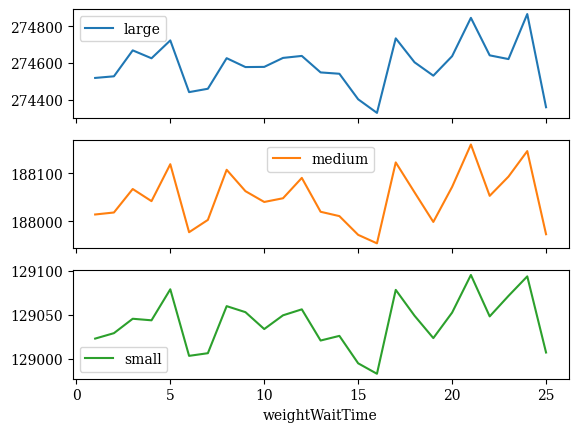

In [30]:
df.cost.groupby([df["weightWaitTime"], df["size_group"]]).mean().unstack().plot(subplots=True);

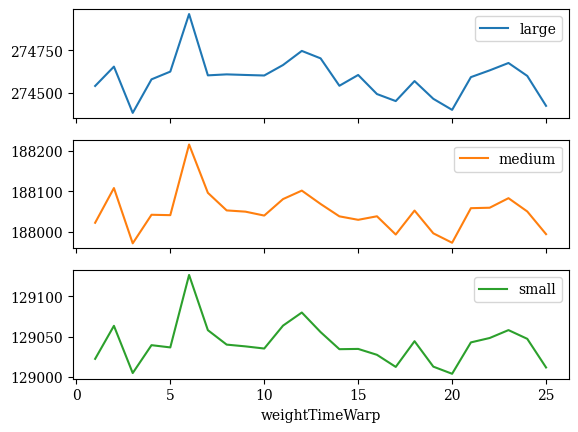

In [31]:
df.cost.groupby([df["weightTimeWarp"], df["size_group"]]).mean().unstack().plot(subplots=True);

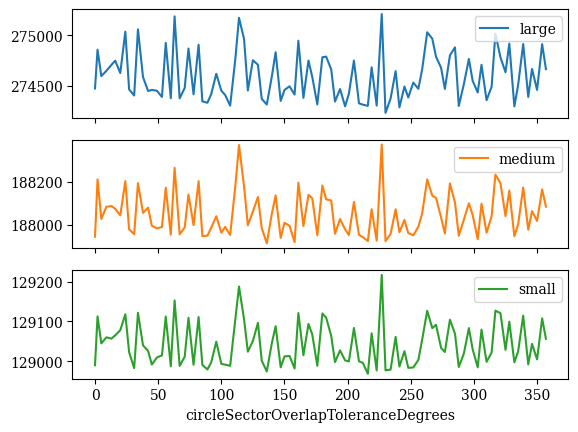

In [32]:
df.cost.groupby([df["circleSectorOverlapToleranceDegrees"], df["size_group"]]).mean().unstack().plot(subplots=True);

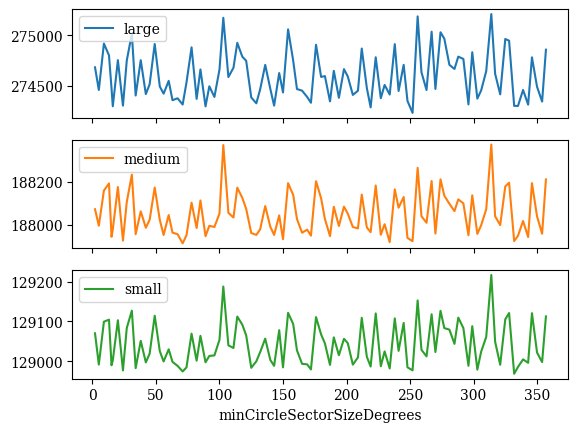

In [33]:
df.cost.groupby([df["minCircleSectorSizeDegrees"], df["size_group"]]).mean().unstack().plot(subplots=True);

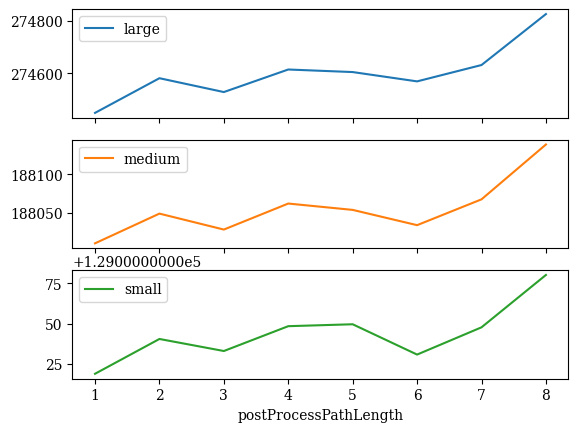

In [34]:
df.cost.groupby([df["postProcessPathLength"], df["size_group"]]).mean().unstack().plot(subplots=True);

In [35]:
mean_value = df[df.exp == 1].cost.mean()

for exp in range(1, 101):
    data = df[df.exp == exp]
    test = stats.ttest_1samp(data.cost, mean_value, alternative='less')
    mean = data.cost.mean()

    if mean <= mean_value:
        print(f"{exp:>3}  {test.pvalue:.2f}  {mean:.0f}")

  1  0.50  164288
 12  0.50  164282
 17  0.50  164282
 20  0.50  164278
 26  0.49  164269
 30  0.50  164278
 39  0.50  164286
 43  0.50  164283
 46  0.50  164281
 47  0.50  164287
 50  0.50  164286
 51  0.50  164279
 56  0.49  164258
 57  0.50  164276
 62  0.49  164259
 65  0.49  164264
 71  0.50  164286
 82  0.49  164259
 95  0.50  164283
 96  0.50  164283


In [36]:
best_per_group = []

for size in ["small", "medium", "large"]:
    grouped = df[df.size_group == size].groupby("exp").cost.mean()
    num_size = len(df[df.size_group == size]) / 1_000
    best_per_group.append((num_size, grouped.min(), grouped.argmin() + 1))

total = len(df) / 1_000
separate_cost = sum(num * val for num, val, _ in best_per_group) / total
print(f"cost of separate configs for each size: {separate_cost:.0f}")

for idx, size in enumerate(["small", "medium", "large"]):
    print(f"{size:>6}: {best_per_group[idx][-1]}")

cost of separate configs for each size: 164251
 small: 82
medium: 56
 large: 62


In [37]:
df[df.exp.isin([56, 62, 82])].groupby("exp").iters.mean()

exp
56    51327.630522
62    50385.493574
82    48067.683936
Name: iters, dtype: float64